# Setting up our environment 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import shutil

shutil.copytree("/content/drive/MyDrive/sar","data/sar")
shutil.copytree("/content/drive/MyDrive/PS-RGB","data/rgb")

'data/rgb'

In [ ]:
!pip install rasterio
!pip install split-folders
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
import splitfolders
splitfolders.ratio('data', output="output", seed=1337, ratio=(.2,0.7,0.1)) 

## Imports

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import rasterio
import os

from rasterio.plot import show
import numpy as np

(900, 900)
(4, 900, 900)


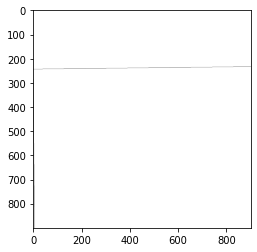

In [ ]:
# ### Reading an sample Image :   
# p="data\PS-RGB\SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif"
# s="data\SAR-Intensity\SN6_Test_Public_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8697.tif"

# image = load_img("/content/data/rgb/SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.tif")
# print(image.size)

# #"/content/output/train/sar/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8679.tif"
# with rasterio.open('/content/data/sar/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804111224_20190804111453_tile_8679.tif') as src:
#     # Read the image data as a numpy array
#     sar_img = src.read() # numpy format
#     print(sar_img.shape)
#     show(sar_img)


# Implementation of our CycleGAN

## Functions to load images and create a numpy array:

In [ ]:



def load_images(path, size=(400,400)):
  data_list = list()
  # enumerate filenames in directory, assume all are images
  for filename in tqdm(listdir(path)):
  # load and resize the image
    try:
      pixels = load_img(os.path.join(path,filename), target_size=size)
      # convert to numpy array
      pixels = img_to_array(pixels)
      # store
      data_list.append(pixels)
    except:
      pass
  return asarray(data_list)



upscale_factor=1/2

def load_images_sar(path, size=(400,400)):
  data_list = list()
  # enumerate filenames in directory, assume all are images
  for filename in tqdm(listdir(path)):
  # load and resize the image
    # try:
      with rasterio.open(os.path.join(path,filename)) as src:
        img_data = src.read(
          out_shape=(
            src.count,
            400,
            400
          ),
          resampling=Resampling.bilinear
        )
        img_data = img_data[:3]
        img_data = np.moveaxis(img_data, 0,-1) 
      data_list.append(img_data)
    # except:
      # pass
  return asarray(data_list)


## Using the functions to create numpy array


In [ ]:
optical_train = load_images("output/train/rgb")
optical_test = load_images("output/test/rgb")
sar_train = load_images_sar("output/train/sar")
sar_test = load_images_sar("output/test/sar")

 84%|████████▍ | 573/681 [00:04<00:00, 135.65it/s]c:\Users\s-sin\AppData\Local\Programs\PythonCodingPack\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 207/207 [00:10<00:00, 18.87it/s]


In [ ]:
optical = vstack((optical_train,optical_test))
sar = vstack((sar_train,sar_test))

print(optical.shape)
print(sar.shape)
filename = 's2o_400.npz'
savez_compressed(filename ,sar, optical)
print('Saved dataset: ', filename)

(1021, 400, 400, 3)
(619, 400, 400, 3)
Saved dataset:  s2o_400.npz


In [ ]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('/content/drive/MyDrive/Shastra/s2o_400.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3



Loaded:  (619, 400, 400, 3) (1021, 400, 400, 3)


# Plot source image


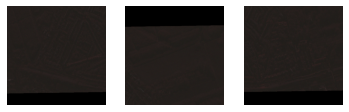

In [ ]:
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))

# Plot target image


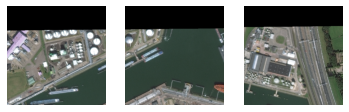

In [ ]:
for i in [0,1,2]:
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
from random import *
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# define layer

layer = InstanceNormalization(axis=-1)
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from matplotlib import pyplot

## Model Architecture

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	print(f"descriminator with {image_shape} starting")
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	print(f"descriminator with {image_shape} done")
	return model


  # generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g


  # define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	print(f"generator with {image_shape} starting")
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	print(f"generator with {image_shape} done")
	return model



  # define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model


  # load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


  # select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y



  # generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y



  # save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 



 # generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()
 


 # update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)
 
 # train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i % 50) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i % 50) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
dataset = load_real_samples('/content/drive/MyDrive/Shastra/s2o_400.npz')

In [ ]:
print('Loaded', dataset[0].shape, dataset[1].shape)


Loaded (619, 400, 400, 3) (1021, 400, 400, 3)


In [ ]:
#training : 
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
image_shape_2 = dataset[1].shape[1:]
print(image_shape)
print(image_shape_2)
print("# generator: A -> B")
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape_2)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape_2)
print("composite: A -> B -> [real/fake, A]")
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
print("composite: B -> A -> [real/fake, B]")
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
print("train models")
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

NameError: ignored